In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

from torch import nn
from torchvision import models
from torchsummary import summary

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

In [4]:
loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [5]:
style_img = image_loader("./picasso.jpg")
content_img = image_loader("./dancing.jpg")

In [6]:
assert style_img.size() == content_img.size()

In [7]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

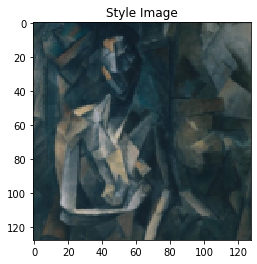

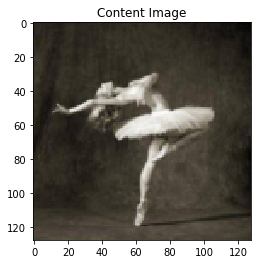

In [8]:
plt.ion()
plt.figure()
imshow(style_img, title='Style Image')
plt.figure()
imshow(content_img, title='Content Image')

In [125]:
class contentLoss(nn.Module):
    def __init__(self, target):
        super(contentLoss, self).__init__()
        self.target = target.detach()
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        self.save = input
        return input

In [182]:
class styleLoss(nn.Module):
    def __init__(self, target, i):
        super(styleLoss, self).__init__()
        self.target = self.gram_matrix(target).detach()
    
    @staticmethod
    def gram_matrix(input):
        a, b, c, d = input.size()
        features = input.view(a * b, c * d)
        G = torch.mm(features, features.t())
        return G.div(a * b * c * d)

    def forward(self, input):
        G = self.gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [183]:
cnn = models.vgg19(weights='VGG19_Weights.IMAGENET1K_V1', progress=True).features.to(device).eval()

In [184]:
class normalize(nn.Module):
    def __init__(self, mean, std):
        super(normalize, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1) # torch.tensor
        self.std = torch.tensor(std).view(-1, 1, 1) # torch.tensor
    
    def forward(self, img):
        return (img - self.mean) / self.std

In [185]:
# style_layers = ['conv_1']
# content_layers = ['conv_1']
content_layers = ['conv_4']
style_layers = ['conv_1' , 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [191]:
def get_model_and_losses(cnn, content_layers, style_layers, content_img, style_img):
    content_losses = []
    style_losses = []

    cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
    normalize_inputs = normalize(cnn_normalization_mean, cnn_normalization_std).to(device)

    model = nn.Sequential(normalize_inputs)

    i = 0
    for layer in cnn:
        if isinstance(layer, nn.Conv2d):
            i += 1
            layer_name = f"conv_{i}"
        elif isinstance(layer, nn.ReLU):
            # i += 1
            layer_name = f"relu_{i}"
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            # i += 1
            layer_name = f"map_pool_2d_{i}"
        else:
            print(f'Unrecognized layer {layer}')
        
        model.add_module(layer_name, layer)

        if layer_name in content_layers:
            target = model(content_img).detach()
            content_loss = contentLoss(target)
            model.add_module(f'content_loss_{i}', content_loss)
            content_losses.append(content_loss)

        if layer_name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = styleLoss(target_feature, i)
            model.add_module(f'style_loss_{i}', style_loss)
            style_losses.append(style_loss)

    for i in range(len(model)-1, -1, -1):
        if isinstance(model[i], styleLoss) or isinstance(model[i], contentLoss):
            break
    model = model[:(i+1)]  
    
    return model, content_losses, style_losses

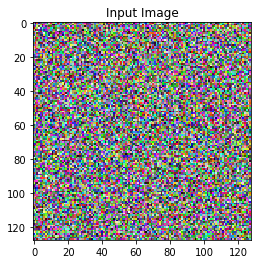

In [190]:
# input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [193]:
import torch.optim as optim
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    # optimizer = optim.LBFGS([input_img])
    optimizer = optim.Adam([input_img])
    return optimizer

In [194]:
num_steps = 150
model, content_losses, style_losses = get_model_and_losses(cnn, content_layers, style_layers, content_img, style_img)
input_img.requires_grad_(True)
model.requires_grad_(False)
optimizer = get_input_optimizer(input_img)
print('Optimizing..')
run = [0]
while run[0] <= num_steps:
    style_weight=1000000
    content_weight=1
    # run[0] += 1
    
    def closure():
        # correct the values of updated input image
        with torch.no_grad():
            input_img.clamp_(0, 1)

        optimizer.zero_grad()
        model(input_img)
        style_score = 0
        content_score = 0

        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss

        style_score *= style_weight
        content_score *= content_weight

        loss = style_score + content_score
        loss.backward()

        
        if run[0] % 50 == 0:
            print("run {}:".format(run))
            print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                style_score.item(), content_score.item()))
            print()

        return style_score + content_score
    optimizer.step(closure)
    run[0] += 1
    print(run[0])
with torch.no_grad():
    input_img.clamp_(0, 1)

c:\Users\abhis\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
c:\Users\abhis\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Optimizing..


In [ ]:
plt.figure()
imshow(input_img, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()